In [1]:
import random
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb

In [3]:
def exp_ign(gp, fp):
    return - gp * math.log(fp, 2) - (1-gp) * math.log(1-fp, 2)

def exp_ign_pts(gp, fp):
    return gp * log_score_538(True, fp) + (1-gp) * log_score_538(False, fp)

def simple_log_score(outcome, forecast_prob):
    return -math.log(forecast_prob, 2) if outcome else -math.log(1 - forecast_prob, 2)

def log_score_538(outcome, forecast_prob):
    return 25 * (1 + math.log(max(forecast_prob, 1 / 14640), 2)) if outcome else \
        25 * (1 + math.log(max(1 - forecast_prob, 1 / 14640), 2)) 


In [4]:
def simulate_person(governing_prob, forecast_prob, N):
    log_scores = { 'simple': [], 'IGN pts': []}
    outcomes = []
    for _ in range(N):
        outcome = random.random() < governing_prob
        outcomes.append(outcome)
        log_scores['simple'].append(simple_log_score(outcome, forecast_prob))
        log_scores['IGN pts'].append(log_score_538(outcome, forecast_prob))
    # For each N, calculate the average log score up to that N for each key in log_scores
    averages = {key: np.cumsum(scores) / np.arange(1, N+1) for key, scores in log_scores.items()}
    return averages, outcomes

In [12]:
# What's my exp(IGN)?
# It's a function of N, p_me, p_gov, and my RAP [default to median]
# I want a certain P(beating p_gov)

def season_me_vs_demon(N, p_gov, a=None, b=None, eps=None):
  my_log_scores = []
  demon_log_scores = []

  # If GDP is not a numeric
  if not isinstance(p_gov, (int, float)):
    if isinstance(N, int):
      gdp = [p_gov(a, b) for _ in range(N)]
    else:
      gdp = [p_gov(a, b) for _ in N]
  else:
    gdp = [p_gov for _ in range(N)]
  
  p_me_list = [p+eps for p in gdp]

  outcomes = [random.random() < p_gov for p_gov in gdp]

  my_log_scores = [log_score_538(outcome, p_me) for outcome, p_me in zip(outcomes, p_me_list)]
  demon_log_scores = [log_score_538(outcome, p_gov) for outcome, p_gov in zip(outcomes, gdp)]

  # For each N, calculate the cumulative IGN pts up to that N
  my_scores = np.cumsum(my_log_scores)
  demon_scores = np.cumsum(demon_log_scores)
  # Did I win? For each of the fp arrays, is my final average log pts > demon's final average log pts?
  winner = my_scores[-1] > demon_scores[-1]
  return winner, my_scores, demon_scores

In [43]:
# Difference in IGN points between demon and p* for each N. Just IGN points.

mw = 4096

N = 32
#gdp = np.random.uniform
gdp = 0.95
a = 0.80
b = 0.99
#gdp_str = f'random.uniform({a}, {b})'
gdp_str = f'{gdp}'
eps = 0.001

# Ultimately I want a dataframe of differences - a distribution of differences for each N
diffdf = pd.DataFrame(columns=range(N), index=range(mw))
for _ in range(mw):
  winner, my_scores, demon_scores = season_me_vs_demon(N, gdp, a, b, eps)
  # Ignore winner - that's only for the N-length season
  diff = my_scores - demon_scores
  # Save the diff for each N as a row in diffdf
  diffdf.loc[_] = diff


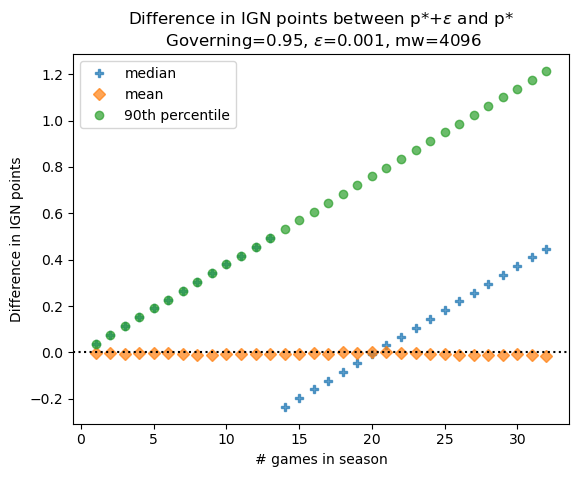

In [44]:
plt.rcParams["mathtext.fontset"] = "dejavusans"

# Rename the columns to N+1
diffdf.columns = range(1, N+1)

# Plot the median, mean, 90th and 95th percentiles of the differences at each N
diffdf.median().plot(style='P', label='median', alpha=0.7)
diffdf.mean().plot(style='D', label='mean', alpha=0.7)
#diffdf.quantile(0.95).plot(style='o', label='95th percentile', alpha=0.7)
diffdf.quantile(0.90).plot(style='o', label='90th percentile', alpha=0.7)
# Add a horizontal dotted line at 0
plt.axhline(0, color='black', linestyle='dotted')
# Add a horizontal line at exp(IGN pts) for p*
plt.legend()
plt.ylabel('Difference in IGN points')
plt.xlabel('# games in season')
# round eps to one significant figure
eps_str = f'{eps:.1g}'
plt.title(f'Difference in IGN points between p*+$\epsilon$ and p*\n Governing={gdp_str}, $\epsilon$={eps_str}, mw={mw}')

plt.savefig(f'Difference in IGN pts - Governing={gdp_str}, $\epsilon$={eps_str}, mw={mw}.png')
# Zoom in on -0.2 to +0.2
#plt.ylim(-0.1, 0.1)

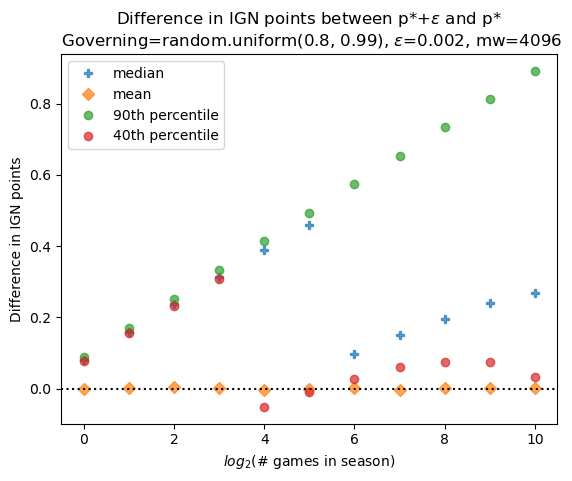

In [26]:

# Difference in IGN points between demon and p* for each N. Just IGN points. But this time with much bigger N. log_2 N = j for j = 0,1,2,...,10

mw = 4096

j = 10
N = [2**j for j in range(0, j+1)]
gdp = np.random.uniform
a = 0.80
b = 0.99
gdp_str = f'random.uniform({a}, {b})'
eps = 0.002

# Ultimately I want a dataframe of differences - a distribution of differences for each N
diffdf = pd.DataFrame(columns=N, index=range(mw))
for _ in range(mw):
  winner, my_scores, demon_scores = season_me_vs_demon(N, gdp, a, b, eps)
  # Ignore winner - that's only for the N-length season
  diff = my_scores - demon_scores
  # Save the diff for each N as a row in diffdf
  diffdf.loc[_] = diff

# Rename the columns to N+1
diffdf.columns = range(0, j+1)

# Plot the median, mean, 90th and 95th percentiles of the differences at each N
diffdf.median().plot(style='P', label='median', alpha=0.7)
diffdf.mean().plot(style='D', label='mean', alpha=0.7)
#diffdf.quantile(0.95).plot(style='o', label='95th percentile', alpha=0.7)
diffdf.quantile(0.90).plot(style='o', label='90th percentile', alpha=0.7)
diffdf.quantile(0.40).plot(style='o', label='40th percentile', alpha=0.7)
# Add a horizontal dotted line at 0
plt.axhline(0, color='black', linestyle='dotted')
# Add a horizontal line at exp(IGN pts) for p*
plt.legend()
plt.ylabel('Difference in IGN points')
plt.xlabel('$log_2$(# games in season)')
# round eps to one significant figure
eps_str = f'{eps:.1g}'
plt.title(f'Difference in IGN points between p*+$\epsilon$ and p*\n Governing={gdp_str}, $\epsilon$={eps_str}, mw={mw}')

plt.savefig(f'Difference in IGN pts - Governing={gdp_str}, $\epsilon$={eps_str}, mw={mw}.png')

In [17]:
diffdf.columns

Index([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], dtype='int64')

## Instant Reliability Significance

538 says it has 383 forecasts of 0.85

How many times wd you expect the fraction of alligned outcomes to be .79 or less?

Histogram of the fraction of alligned forecasts over many worlds, each one with 383 forecasts of 85%

519 forecasts of 0.31, what’s the chance 28% (or less) of the outcomes were aligned?

Display a little cdf with a virtical line at .28 (and a cross hair to the cumulative p axis)

In [25]:
def exp_frac_aligned(N=383, p_gov=.85, lessthan=.79, mw=4096):
  fracaligned = []
  for _ in range(mw):
    outcomes = [random.random() < p_gov for _ in range(N)]
    fracaligned.append(sum(outcomes) / N)
  # count number of true in fracaligned
  res = sum([1 for x in fracaligned if x < lessthan]) / mw
  # Display a little cdf with a vertical line at lessthan
  plt.hist(fracaligned, bins=100, cumulative=False, density=True)
  plt.axvline(lessthan, color='red')
  # Title should include res rounded to three sig figs
  plt.title(f'Instant Reliability Significance\nN={N}, p_gov={p_gov}, mw={mw}')
  # Make a legend box with the result
  plt.legend([f'P(fracaligned < {lessthan}) = {res:.3g}'])
  return fracaligned

[0.8590078328981723,
 0.8381201044386423,
 0.8381201044386423,
 0.8537859007832899,
 0.856396866840731,
 0.8459530026109661,
 0.8485639686684073,
 0.8642297650130548,
 0.8616187989556136,
 0.8302872062663186,
 0.8224543080939948,
 0.8172323759791122,
 0.8407310704960835,
 0.8642297650130548,
 0.8407310704960835,
 0.8433420365535248,
 0.8459530026109661,
 0.8772845953002611,
 0.8616187989556136,
 0.8511749347258486,
 0.8120104438642297,
 0.8407310704960835,
 0.8433420365535248,
 0.8433420365535248,
 0.8642297650130548,
 0.8381201044386423,
 0.856396866840731,
 0.8772845953002611,
 0.825065274151436,
 0.814621409921671,
 0.8590078328981723,
 0.8798955613577023,
 0.8720626631853786,
 0.8537859007832899,
 0.835509138381201,
 0.8590078328981723,
 0.8642297650130548,
 0.8668407310704961,
 0.8825065274151436,
 0.8511749347258486,
 0.8720626631853786,
 0.8511749347258486,
 0.8407310704960835,
 0.8511749347258486,
 0.8746736292428199,
 0.8590078328981723,
 0.8381201044386423,
 0.817232375979112

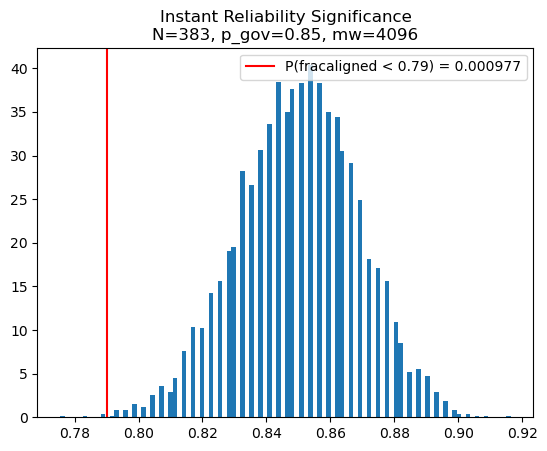

In [28]:
exp_frac_aligned()

[0.30828516377649323,
 0.3217726396917148,
 0.30828516377649323,
 0.3179190751445087,
 0.3333333333333333,
 0.3140655105973025,
 0.3179190751445087,
 0.2928709055876686,
 0.3140655105973025,
 0.2947976878612717,
 0.30828516377649323,
 0.3044315992292871,
 0.325626204238921,
 0.3217726396917148,
 0.3217726396917148,
 0.3159922928709056,
 0.2697495183044316,
 0.279383429672447,
 0.32947976878612717,
 0.32755298651252407,
 0.3236994219653179,
 0.3159922928709056,
 0.325626204238921,
 0.3159922928709056,
 0.33140655105973027,
 0.2947976878612717,
 0.3179190751445087,
 0.302504816955684,
 0.30828516377649323,
 0.3179190751445087,
 0.30057803468208094,
 0.34104046242774566,
 0.3468208092485549,
 0.35645472061657035,
 0.33140655105973027,
 0.2678227360308285,
 0.325626204238921,
 0.2947976878612717,
 0.29672447013487474,
 0.3044315992292871,
 0.2813102119460501,
 0.3352601156069364,
 0.302504816955684,
 0.2928709055876686,
 0.31021194605009633,
 0.31021194605009633,
 0.34104046242774566,
 0.2

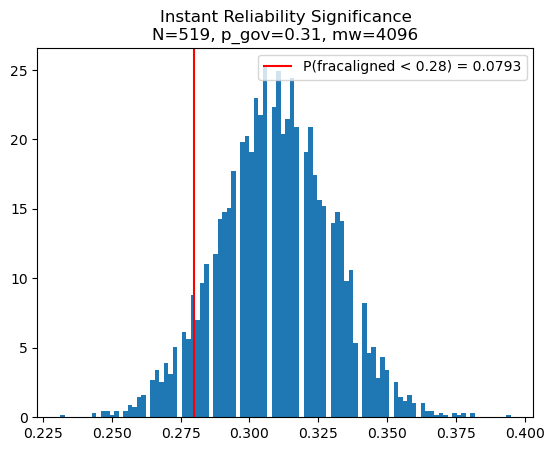

In [27]:
exp_frac_aligned(519, .31, .28)

/tmp/ipykernel_508652/2898166759.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot([n] * len(y), y, 'bo', alpha=0.8, color='plum')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


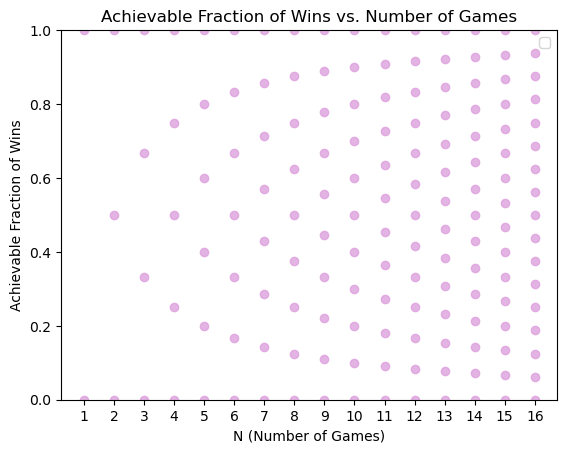

In [67]:
def achievable_fraction_of_wins(n):
    return [i / n for i in range(n + 1)]

def plot_graph():
    x = list(range(1, 17))
    for n in x:
        y = achievable_fraction_of_wins(n)
        plt.plot([n] * len(y), y, 'bo', alpha=0.8, color='plum')
        #plt.text(n, 0.5, f'N={n}', rotation=45)
    
    plt.xlabel('N (Number of Games)')
    plt.ylabel('Achievable Fraction of Wins')
    plt.title('Achievable Fraction of Wins vs. Number of Games')
    plt.xticks(list(range(1, 17)))
    plt.ylim(0, 1)
    plt.legend()
    #plt.grid(True)
    plt.show()

plot_graph()


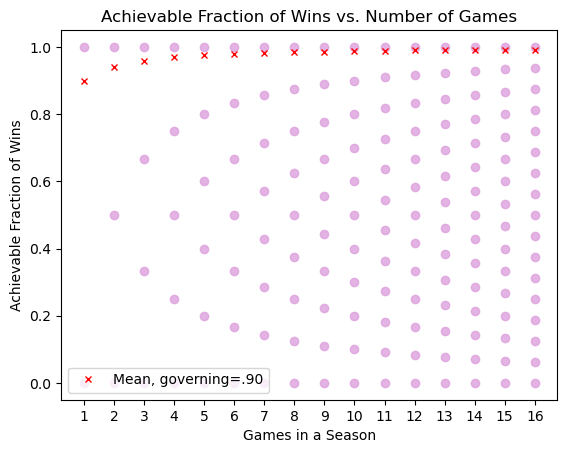

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def achievable_fraction_of_wins(n):
    return [i / n for i in range(n + 1)]

def weighted_mean(fractions, p_win=0.9):
    weights = [p_win ** k * (1 - p_win) ** (len(fractions) - k) for k in range(len(fractions))]
    return np.average(fractions, weights=weights)

def plot_graph():
    x = list(range(1, 17))
    for n in x:
        y = achievable_fraction_of_wins(n)
        plt.plot([n] * len(y), y, 'o', alpha=0.8, color='plum')  # Purple dots
        if n == 1:
            plt.plot(n, weighted_mean(y), 'rx', markersize=5, label='Mean, governing=.90')  # Red cross for weighted mean with label
        else:
            plt.plot(n, weighted_mean(y), 'rx', markersize=5)  # Red cross for weighted mean without label
    
    plt.xlabel('Games in a Season')
    plt.ylabel('Achievable Fraction of Wins')
    plt.title('Achievable Fraction of Wins vs. Number of Games')
    plt.xticks(list(range(1, 17)))
    plt.ylim(-0.05, 1.05)  # Adjusted y-axis limits
    plt.legend(loc='lower left')  # Placing legend in the upper left corner
    plt.show()

plot_graph()



In [435]:
season_me_vs_demon(N, gdp)

(True,
 array([20.69491978, 22.37150524, 22.1451023 , 21.90987439, 21.02958524,
        21.52262123, 13.57881839, 14.64052067,  8.74992835,  9.99853361,
        11.12934322, 12.14786793, 12.63407565, 13.0532962 , 13.64124372,
        14.06834414, 14.31952715, 14.68297595, 15.08642669, 15.45923581,
        15.77543959, 16.01012499, 16.26576253, 16.34194099, 16.56088794,
        16.64101141, 16.70452515, 16.91357901, 17.00715578, 17.23866679,
        17.31467537, 17.40830078]),
 array([20.65425695, 22.33264833, 22.1060133 , 21.87053454, 20.98922914,
        21.48280564, 13.57113575, 14.62890609,  8.76276356, 10.0060796 ,
        11.13268103, 12.14777978, 12.63066709, 13.04704453, 13.63278511,
        14.05785719, 14.30710356, 14.66899393, 15.07113638, 15.44277846,
        15.7579036 , 15.99155022, 16.24628505, 16.32145403, 16.53964373,
        16.61892877, 16.68165339, 16.89014501, 16.98308553, 17.21416057,
        17.28960732, 17.38273177]))

In [436]:
winners = []
numworlds = 2048

for i in range(numworlds):
  winners.append(season_me_vs_demon(N, gdp)[0])

winners

[True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 

In [437]:
# Sum each column
percent_mw_wins = sum(winners)/numworlds

percent_mw_wins

0.53564453125

Next (moving forward rather than tidying up) is to pick N=64 and plot orange and blue dots as a function of p_gov. 

Say N_season = 32

MW 2048

P-gov U ( .68, .995)
- N_season = 32
- Do 2047 many worlds with eps=0.001, GDP U(.8, .99)

In [534]:

import matplotlib.patches as mpatches

def orangeBlue_pgov(numworlds, N_seasons, a, b):
  # UNSURE WHAT WE WANT HERE NOW
  return(0)

In [535]:
orangeBlue_pgov(12, 32, 0.001, 0.005)

0


Plot x=N, y=percentage that wins
One world, one point.

Plot these in blue.
Then repeat with eps = +0.005 and plot these in orange

In [532]:
def orangeBlue(numworlds, N_seasons, a, b):
  Ns = range(8, 128, 8)
  # Initialize dictionary with empty list for each N
  percent_mw_wins_blue = {N: [] for N in Ns}
  percent_mw_wins_orange = {N: [] for N in Ns}

  for N in Ns:
    for _ in range(numworlds):
      winners_blue = []
      winners_orange = []
      gdp = [np.random.uniform(.80, .99) for _ in range(N)]
      gdp_str = 'U(.80, .99)'
      blue = [p + a for p in gdp]
      orange = [p + a for p in gdp]
      for _ in range(N_seasons):
        winners_blue.append(season_me_vs_demon(N, gdp, blue)[0])
        winners_orange.append(season_me_vs_demon(N, gdp, orange)[0])
      percent_mw_wins_blue[N].append(sum(winners_blue)/N_seasons)
      percent_mw_wins_orange[N].append(sum(winners_orange)/N_seasons)
  
  # Plot percent_mw_wins_blue and _orange (keys are X, values are Y). There are multiple Ys for each X
  for N in Ns:
    plt.scatter([N]*numworlds, percent_mw_wins_blue[N], color="blue", alpha=0.5)
    plt.scatter([N]*numworlds, percent_mw_wins_orange[N], color="orange", alpha=0.5)
  # X axis label N (games)
  plt.xlabel('N (games in season)')
  # Y axis label % of wins
  plt.ylabel('% of wins')
  # Title U(.8, .99)
  plt.title(f'{gdp_str}, {numworlds} worlds, {N_seasons} seasons per world')

  # Plot median for each (orange and blue)
  plt.plot(Ns, [np.median(percent_mw_wins_blue[N]) for N in Ns], color='blue', alpha = 0.5)
  plt.plot(Ns, [np.median(percent_mw_wins_orange[N]) for N in Ns], color='orange', alpha = 0.5)


  # Add a legend. Orange is "+0.005" and Blue is "+0.001" and I need you to add it by hand
  blue_patch = mpatches.Patch(color='blue', label=f'+{a}')
  orange_patch = mpatches.Patch(color='orange', label=f'+{b}')
  plt.legend(handles=[orange_patch, blue_patch])

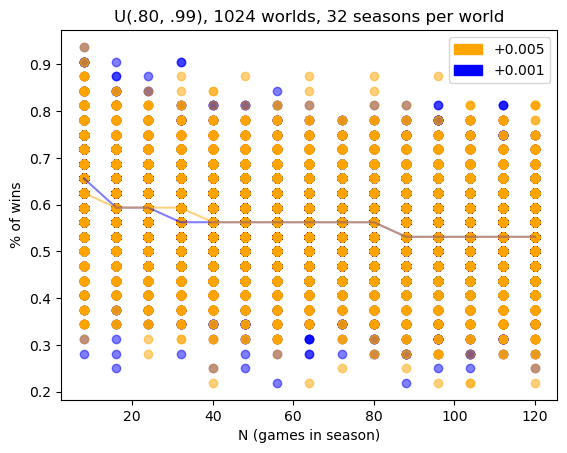

In [533]:
orangeBlue(1024, 32, 0.001, 0.005)

Graph A1: (p_gov = 90, p* = 0.91)

Y (0,1)

X (1,16): k = (0, x) a black point on the achievable values (possible outcomes i/x i=0,x )for each integer value of x

For a given p_gov (say 0.90) a horizontal line at the expected value.

A green line through the achievable values that include the many worlds median.

    - - - - - - -

Graph A1 shows merely that it is possible to expect to beat the expected value of p_gov. Next consider each set of outcomes, k, and determine whether or not p* outperforms p_gov in that set.

In [13]:
# Remove all variables from memory
%reset -f

In [21]:
# Assuming some values for governing_prob, forecast_prob, and num_people
governing_prob = 0.90
forecast_prob = 0.905

In [23]:
N = 16
num_people = 2048

medians = {}
means = {}
p92 = {}
p08 = {}

medians_diff = {}
means_diff = {}
p92_diff = {}
p08_diff = {}

# Simulate num_people and calculate the log scores
#log_scores = [simulate_person(governing_prob, forecast_prob, N)[0] for _ in range(num_people)]

score_differences = []
log_scores = []

for _ in range(num_people):
    log_scores_ind, outcomes = simulate_person(governing_prob, forecast_prob, N)
    forecasted_p_gov_scores_simple = [simple_log_score(outcome, governing_prob) for outcome in outcomes]
    forecasted_p_gov_scores_pts = [log_score_538(outcome, governing_prob) for outcome in outcomes]
    
    # Calculate the cumulative sum of forecasted_p_gov_scores
    forecasted_p_gov_scores_simple_cumsum = np.cumsum(forecasted_p_gov_scores_simple)
    forecasted_p_gov_scores_pts_cumsum = np.cumsum(forecasted_p_gov_scores_pts)
    
    differences = { 'simple': [], 'IGN pts': []}

    # Calculate the difference in scores
    differences['simple'] = [log_scores_ind['simple'][i] - forecasted_p_gov_scores_simple_cumsum[i] for i in range(len(outcomes))]
    differences['IGN pts'] = [log_scores_ind['IGN pts'][i] - forecasted_p_gov_scores_pts_cumsum[i] for i in range(len(outcomes))]
    
    score_differences.append(differences)
    log_scores.append(log_scores_ind)


# Make a dataframe where columns are repetitions and rows are people
df = pd.DataFrame(log_scores)

# For each column (repetition) in df, get the median, mean, and 90th percentile
column_names = list(df.columns)  # Add more column names/keys here if needed

# Assuming each dictionary in log_scores has the same keys
keys = log_scores[0].keys()

for key in keys:
    # Extract the arrays for the current key from each dictionary in log_scores
    arrays = [person[key] for person in log_scores]

    # Stack these arrays vertically
    stacked_arrays = np.vstack(arrays)

    # Calculate the median across rows (i.e., across all people) for each column
    medians[key] = np.median(stacked_arrays, axis=0)
    means[key] = np.mean(stacked_arrays, axis=0)
    p92[key] = np.quantile(stacked_arrays, 0.92, axis=0)
    p08[key] = np.quantile(stacked_arrays, 0.08, axis=0)

# Difference in cumulative scores between p* and p_gov
df_diff = pd.DataFrame(score_differences)

for key in keys:
  # Extract the arrays for the current key from each dictionary in score_differences
  arrays = [person[key] for person in score_differences]

  # Stack these arrays vertically
  stacked_arrays = np.vstack(arrays)

  # Calculate the median across rows (i.e., across all people) for each column
  medians_diff[key] = np.median(stacked_arrays, axis=0)
  means_diff[key] = np.mean(stacked_arrays, axis=0)
  p92_diff[key] = np.quantile(stacked_arrays, 0.92, axis=0)
  p08_diff[key] = np.quantile(stacked_arrays, 0.08, axis=0)

In [68]:
log_scores

{'simple': array([3.32192809, 1.73696559, 1.20864476, 0.94448434, 1.41997309,
        1.20864476, 1.05769595, 0.94448434, 1.20864476, 1.41997309,
        1.59287809, 1.47280518, 1.6150454 , 1.51054238, 1.41997309,
        1.53884528]),
 'IGN pts': array([-58.04820237, -18.42413985,  -5.21611901,   1.3878914 ,
        -10.49932735,  -5.21611901,  -1.44239877,   1.3878914 ,
         -5.21611901, -10.49932735, -14.82195235, -11.82012943,
        -15.37613505, -12.76355949, -10.49932735, -13.47113204])}

In [42]:
simulate_person(.97, .98, 3)[0]

{'simple': array([0.02914635, 0.02914635, 0.02914635]),
 'IGN pts': array([24.27134136, 24.27134136, 24.27134136])}

In [43]:
# Write df to a csv called "df_N40_R500.csv", no row names
df.to_csv(f"df_N{N+1}_{num_people}worlds_{governing_prob}governing_{forecast_prob}forecast.csv", index=False)

In [44]:
medians

{'simple': array([0.1440103 , 0.1440103 , 0.1440103 , 0.1440103 , 0.1440103 ,
        0.1440103 , 0.60857007, 0.5505001 , 0.50533457, 0.46920214,
        0.43963925, 0.4150035 , 0.39415787, 0.37629019, 0.36080486,
        0.3472552 ]),
 'IGN pts': array([21.39974243, 21.39974243, 21.39974243, 21.39974243, 21.39974243,
        21.39974243,  9.78574824, 11.23749752, 12.36663584, 13.2699465 ,
        14.00901886, 14.62491249, 15.14605325, 15.59274534, 15.97987848,
        16.31861997])}

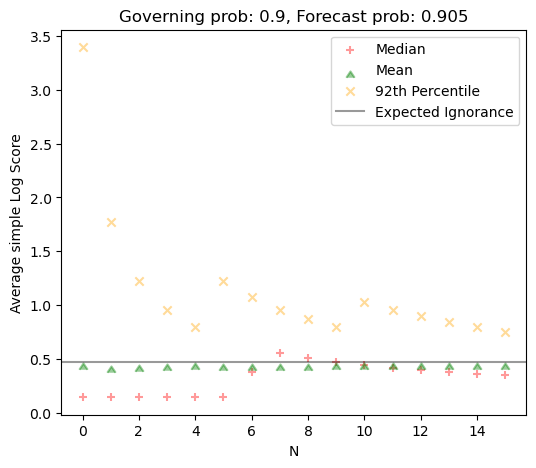

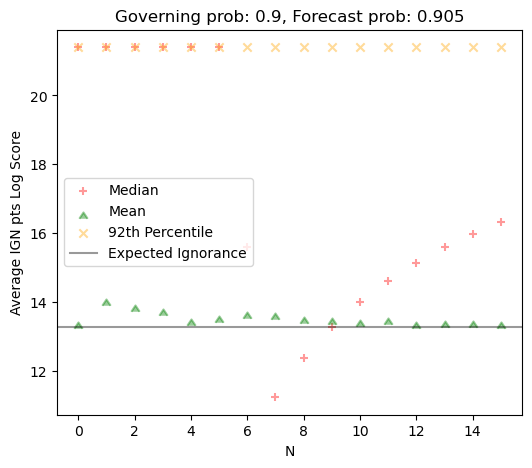

In [78]:
for col in column_names:
    # Create line plots for median, mean, and percentile
    N_values = range(N)
    plt.scatter(N_values, medians[col], color='red', label='Median', marker = '+', alpha = 0.4)
    plt.scatter(N_values, means[col], color='green', label='Mean', marker = 6, alpha = 0.4)
    plt.scatter(N_values, p92[col], color='orange', label='92th Percentile', marker = 'x', alpha = 0.4)
    #plt.scatter(N_values, p08[col], color='blue', label='8th Percentile', marker = 'x', alpha = 0.4)

    # If column name is "simple," add horizontal line at exp_ign(governing_prob, forecast_prob)
    if col == 'simple':
        plt.axhline(y=exp_ign(governing_prob, forecast_prob), color='black', label='Expected Ignorance', alpha = 0.4)
    elif col == 'IGN pts':
        plt.axhline(y=exp_ign_pts(governing_prob, forecast_prob), color='black', label='Expected Ignorance', alpha = 0.4)

    # Set the labels for the x and y axes
    plt.title(f'Governing prob: {governing_prob}, Forecast prob: {forecast_prob}')
    plt.xlabel('N')
    plt.ylabel(f'Average {col} Log Score')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

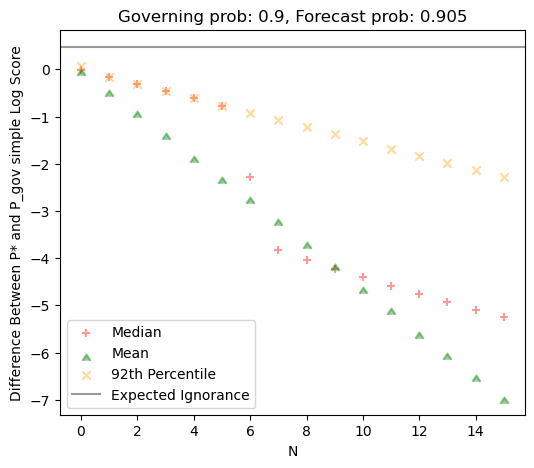

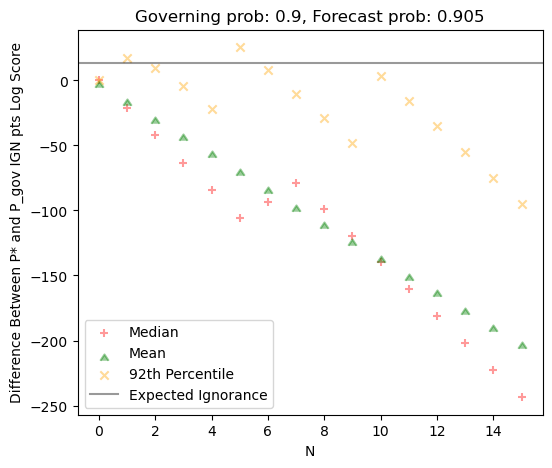

In [79]:
# SAME BUT DIFFERENCE BETWEEN P* AND P_GOV PTS

for col in column_names:
    # Create line plots for median, mean, and percentile
    N_values = range(N)
    plt.scatter(N_values, medians_diff[col], color='red', label='Median', marker = '+', alpha = 0.4)
    plt.scatter(N_values, means_diff[col], color='green', label='Mean', marker = 6, alpha = 0.4)
    plt.scatter(N_values, p92_diff[col], color='orange', label='92th Percentile', marker = 'x', alpha = 0.4)
    #plt.scatter(N_values, p08[col], color='blue', label='8th Percentile', marker = 'x', alpha = 0.4)

    # If column name is "simple," add horizontal line at exp_ign(governing_prob, forecast_prob)
    if col == 'simple':
        plt.axhline(y=exp_ign(governing_prob, forecast_prob), color='black', label='Expected Ignorance', alpha = 0.4)
    elif col == 'IGN pts':
        plt.axhline(y=exp_ign_pts(governing_prob, forecast_prob), color='black', label='Expected Ignorance', alpha = 0.4)

    # Set the labels for the x and y axes
    plt.title(f'Governing prob: {governing_prob}, Forecast prob: {forecast_prob}')
    plt.xlabel('N')
    plt.ylabel(f'Difference Between P* and P_gov {col} Log Score')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

In [24]:
# For the next part I need to make df['simple'] a dataframe
ss = pd.DataFrame(df['simple'].tolist())
ff = pd.DataFrame(df['IGN pts'].tolist())

In [47]:
ss

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.144010,1.769969,1.227983,0.95699,0.794394,0.685997,0.60857,0.55050,0.866659,0.794394,0.735268,0.685997,0.644305,0.60857,0.577599,0.550500
1,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010,0.14401,0.14401,0.505335,0.794394,0.735268,0.685997,0.644305,0.60857,0.577599,0.550500
2,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010,0.14401,0.14401,0.144010,0.144010,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010
3,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010,0.14401,0.14401,0.144010,0.144010,0.144010,0.144010,0.144010,0.14401,0.144010,0.347255
4,0.144010,0.144010,0.144010,0.14401,0.144010,0.685997,0.60857,0.55050,0.505335,0.794394,0.735268,0.685997,0.644305,0.60857,0.577599,0.550500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010,0.14401,0.55050,0.505335,0.469202,0.439639,0.415004,0.394158,0.37629,0.360805,0.347255
496,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010,0.14401,0.14401,0.144010,0.469202,0.439639,0.415004,0.394158,0.37629,0.360805,0.347255
497,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010,0.14401,0.14401,0.144010,0.144010,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010
498,0.144010,0.144010,0.144010,0.14401,0.144010,0.144010,0.14401,0.14401,0.144010,0.144010,0.439639,0.415004,0.394158,0.37629,0.360805,0.347255


Text(0, 0.5, 'Simple Log Score')

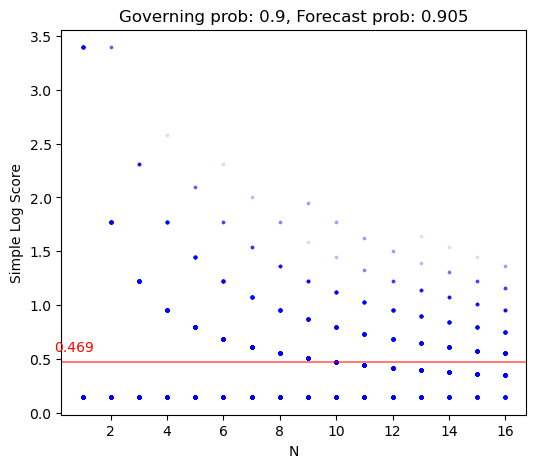

In [48]:
plt.rcParams['figure.figsize'] = [6, 5]

# On top of that, plot faintly all the log score dots (df) individually, in a column for each N
for N in range(1, N+1):
    plt.scatter([N] * num_people, ss[N-1], color='blue', alpha=0.1, s=3)

xx = exp_ign(governing_prob, forecast_prob)
# Plot horizontal line at y = xx
plt.axhline(y=xx, color='r', linestyle='-', alpha = 0.5)
# Label that line with value xx and move it up a little bit
plt.text(0, xx + 0.1, f'{xx:.3f}', color='r')
# Title
plt.title(f'Governing prob: {governing_prob}, Forecast prob: {forecast_prob}')
# x-axis
plt.xlabel('N')
# y-axis
plt.ylabel('Simple Log Score')

Text(0, 0.5, 'IGN Pts')

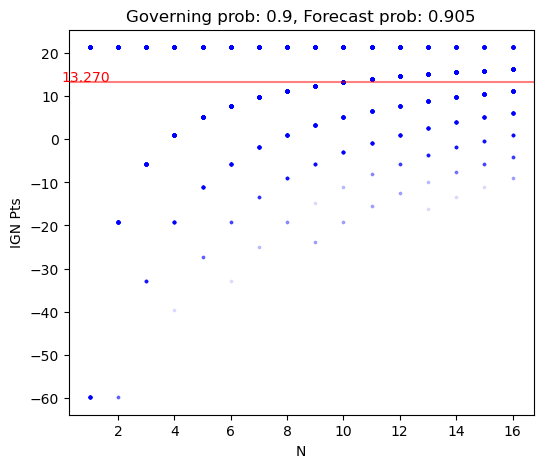

In [49]:
# On top of that, plot faintly all the log score dots (df) individually, in a column for each N
for N in range(1, N+1):
    plt.scatter([N] * num_people, ff[N-1], color='blue', alpha=0.1, s=3)

xx = exp_ign_pts(governing_prob, forecast_prob)
# Plot horizontal line at y = xx
plt.axhline(y=xx, color='r', linestyle='-', alpha = 0.5)
# Label that line with value xx and move it up a little bit
plt.text(0, xx + 0.1, f'{xx:.3f}', color='r')
# Title
plt.title(f'Governing prob: {governing_prob}, Forecast prob: {forecast_prob}')
# x-axis
plt.xlabel('N')
# y-axis
plt.ylabel('IGN Pts')

In [50]:
# What's the frequency of the minimum number in each column of ss? Just the minimum number

min_freq = {}
for col in ss.columns:
    min_val = ss[col].min()
    freq = ss[col].value_counts()[min_val]
    min_freq[col] = freq

min_freq

{0: 445,
 1: 400,
 2: 356,
 3: 321,
 4: 291,
 5: 261,
 6: 235,
 7: 214,
 8: 200,
 9: 182,
 10: 162,
 11: 154,
 12: 141,
 13: 128,
 14: 114,
 15: 106}

In [51]:
min(ss[N-1])

0.1440103026915193

In [52]:
ss[N-1].value_counts().sort_index()

15
0.144010    106
0.347255      8
0.347255     13
0.347255     46
0.347255     54
0.347255     44
0.550500      1
0.550500     68
0.550500     69
0.753745     26
0.753745     35
0.956990      5
0.956990     13
1.160235      1
1.160235      8
1.363480      3
Name: count, dtype: int64

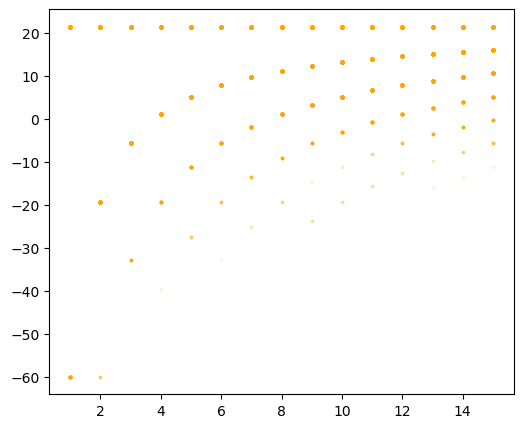

In [53]:
for N in range(1, N):
    plt.scatter([N] * num_people, ff[N-1], color='orange', alpha=0.1, s=3)

In [54]:
import numpy as np
from math import factorial

# Redefine the binomial_coefficient and simple_log_score functions
def binomial_coefficient(n, k):
    """Calculate the binomial coefficient 'n choose k'."""
    return factorial(n) // (factorial(k) * factorial(n - k))

def calculate_efficient_stats(total_games, actual_win_probability, forecast_probability, scoring_function, percentiles=[50]):
    # Initialize arrays for statistics
    mean_scores = []
    median_scores = []
    percentile_scores = {p: [] for p in percentiles}

    # Calculate scores for win and loss
    win_score = scoring_function(True, forecast_probability)
    loss_score = scoring_function(False, forecast_probability)

    for num_games in range(1, total_games + 1):
        # Compute probabilities for all possible numbers of wins
        probabilities = np.array([binomial_coefficient(num_games, wins) * (actual_win_probability ** wins) * ((1 - actual_win_probability) ** (num_games - wins)) 
                         for wins in range(num_games + 1)])

        # Compute the scores for all possible outcomes
        scores = np.array([(win_score * wins + loss_score * (num_games - wins)) / num_games for wins in range(num_games + 1)])

        # Calculate the mean, median and percentiles
        weighted_scores = scores * probabilities
        mean_scores.append(weighted_scores.sum() / probabilities.sum())
        scores_repeated = np.repeat(scores, (probabilities * 10000).astype(int))  # Approximation for median and percentiles
        median_scores.append(np.median(scores_repeated))
        for p in percentiles:
            percentile_scores[p].append(np.percentile(scores_repeated, p))

    return mean_scores, median_scores, percentile_scores

In [55]:
# Example with 10 games, win probability of 0.5, and the simple_log_score function
total_games = 1000

# Example calculation with 8th and 92nd percentiles
mean_scores, median_scores, percentile_scores = calculate_efficient_stats(total_games, governing_prob, forecast_prob, simple_log_score, [8, 92])

Text(0, 0.5692021400554812, '0.469')

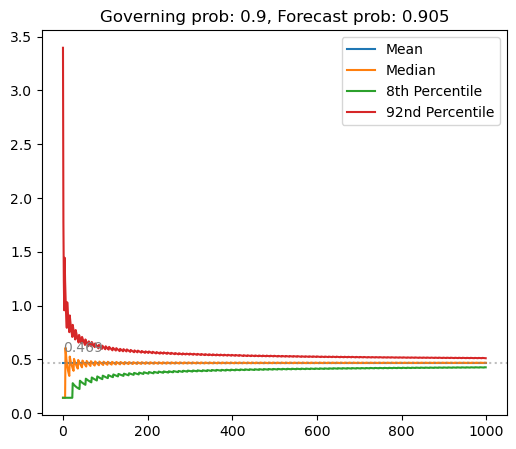

In [56]:
# Plot the series of means, medians, 8th and 92nd percentile scores. X axis is index. Y axis is score. All in one.
plt.plot(mean_scores, label='Mean')
plt.plot(median_scores, label='Median')
plt.plot(percentile_scores[8], label='8th Percentile')
plt.plot(percentile_scores[92], label='92nd Percentile')
# Show labels
plt.legend()
plt.title(f'Governing prob: {governing_prob}, Forecast prob: {forecast_prob}')

xx = exp_ign(governing_prob, forecast_prob)
# Plot horizontal line at y = xx
plt.axhline(y=xx, color='grey', linestyle='dotted', alpha = 0.5)
# Label that line with value xx and move it up a little bit
plt.text(0, xx + 0.1, f'{xx:.3f}', color='grey')

In [57]:
governing_prob = 0.90
forecast_prob = 0.96

mean_scores, median_scores, percentile_scores = calculate_efficient_stats(total_games, governing_prob, forecast_prob, simple_log_score, [8, 92])

In [58]:
governing_prob = 0.75
forecast_prob = 0.90

mean_scores, median_scores, percentile_scores = calculate_efficient_stats(total_games, governing_prob, forecast_prob, simple_log_score, [8, 92])

In [59]:
def generate_combinatorics_average_score_table(total_games, forecast_probability, scoring_function):
    table = []

    # Calculate individual game scores for win and loss based on the forecast probability
    win_score = scoring_function(True, forecast_probability)
    loss_score = scoring_function(False, forecast_probability)

    for wins in range(total_games + 1):
        losses = total_games - wins
        ways = binomial_coefficient(total_games, wins)

        # Average score for this outcome (wins and losses)
        average_score = (wins * win_score + losses * loss_score) / total_games

        table.append({"Wins": wins, "Losses": losses, "Ways": ways, f"Average Score given {forecast_probability}": average_score})

    return table

# Generate combinatorics average score table for 10 games with a forecast probability of 90%
mytable = generate_combinatorics_average_score_table(40, forecast_prob, simple_log_score)
mytable

[{'Wins': 0,
  'Losses': 40,
  'Ways': 1,
  'Average Score given 0.9': 3.3219280948873626},
 {'Wins': 1,
  'Losses': 39,
  'Ways': 40,
  'Average Score given 0.9': 3.2426799698513045},
 {'Wins': 2,
  'Losses': 38,
  'Ways': 780,
  'Average Score given 0.9': 3.163431844815247},
 {'Wins': 3,
  'Losses': 37,
  'Ways': 9880,
  'Average Score given 0.9': 3.0841837197791895},
 {'Wins': 4,
  'Losses': 36,
  'Ways': 91390,
  'Average Score given 0.9': 3.0049355947431313},
 {'Wins': 5,
  'Losses': 35,
  'Ways': 658008,
  'Average Score given 0.9': 2.9256874697070736},
 {'Wins': 6,
  'Losses': 34,
  'Ways': 3838380,
  'Average Score given 0.9': 2.846439344671016},
 {'Wins': 7,
  'Losses': 33,
  'Ways': 18643560,
  'Average Score given 0.9': 2.767191219634958},
 {'Wins': 8,
  'Losses': 32,
  'Ways': 76904685,
  'Average Score given 0.9': 2.6879430945989},
 {'Wins': 9,
  'Losses': 31,
  'Ways': 273438880,
  'Average Score given 0.9': 2.608694969562842},
 {'Wins': 10,
  'Losses': 30,
  'Ways': 8476

In [60]:
# Save that table to a csv please
pd.DataFrame(mytable).to_csv('combinatorics_and_scores_90_table.csv', index=False)